# Tutorial: Solving PDEs with forward Euler Time-Stepping

This notebook demonstrates how to solve PDEs using the quantum algorithm with forward Euler time-stepping described in [Lubasch et al., “Variational quantum algorithms for nonlinear problems” (PR A, 2019)](https://arxiv.org/pdf/1907.09032). It walks through setting up the problem, preparing the initial quantum state, running the time evolution, and visualizing the results. The notebook also includes a section for comparing the quantum solver with a classical PDE solver.

In [1]:
# imports

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

import matplotlib.pyplot as plt
import numpy as np

from src.utils import set_seeds, gaussian_state, fix_lambda0_sign
from src.ansatz import HEAnsatz
from src.pdes import Diffusion2D
from src.ref_solutions import DiffusionFiPySolver
from src.plot import time_evolution_dataframe_2d, plot_time_evolution_2d
from src.time_evo import (
    prepare_initial_state,
    run_time_evolution,
)

## Quantum PDE Solver

In [2]:
# --- User parameters (edit these directly) ---
n_qubits = 4          # Number of qubits (must be even for 2D)
depth = 2             # Ansatz circuit depth
tau = 0.25             # Euler time step
D = 0.1               # Diffusion coefficient
tmax = 5.0            # Total simulation time
sigma = 0.15          # Initial Gaussian width
seed = 88983          # Random seed

# --- Setup ---
set_seeds(seed, verbose=False)
domain = [(0.0, 1.0), (0.0, 1.0)]
nsteps = int(tmax / tau)

In [ ]:
# --- Initial State Preparation ---
print("\n------ Initial State Preparation ------\n")
target = gaussian_state(n_qubits, domain=domain, sigma=sigma)
lambdas, init_fidelity = prepare_initial_state(
    n_qubits=n_qubits,
    depth=depth,
    target=target,
)
lambda0 = 1.0  # Initial scaling factor
lambda0 = fix_lambda0_sign(HEAnsatz(n_qubits, depth), lambdas, lambda0, target)
print("Optimal λ parameters:\n- λ0:", lambda0, "\n- λ:", lambdas)
print("Final fidelity:", init_fidelity)

# --- Time Evolution ---
print("\n------ Time Evolution ------\n")
df = run_time_evolution(
    lambda0=lambda0,
    lambdas=lambdas,
    pde=Diffusion2D(lambda0, lambdas, D, tau, n_qubits, depth),
    nsteps=nsteps,
    verbose=False,
)

# --- Results Processing & Plotting ---
print("\n------ Results Processing ------\n")
df_funcs = time_evolution_dataframe_2d(df, n_qubits, depth, domain)
plot_time_evolution_2d(df_funcs, max_plots=6, outfile=None)  # Show plot, do not save


------ Initial State Preparation ------

Optimal λ parameters:
- λ0: 1.0 
- λ: [ 0.89952097  2.22604923  1.46625246  1.12406526 -0.54108772  1.06519961
  0.95766252  1.40039907]
Final fidelity: 0.9583854346492209

------ Time Evolution ------



## Classical PDE Solver for Comparison

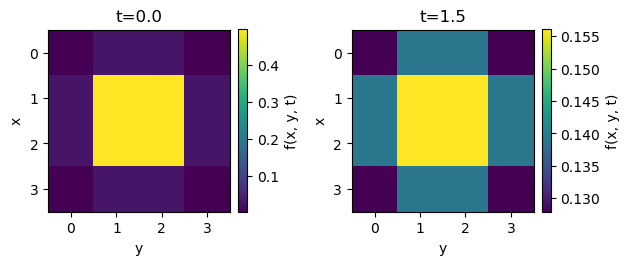

In [ ]:
grid_size = int(np.sqrt(2**n_qubits))
solver = DiffusionFiPySolver(
    dim=len(domain), 
    nx=grid_size, 
    ny=grid_size, 
    Lx=domain[0][1]-domain[0][0], 
    Ly=domain[1][1]-domain[1][0],
)
history = solver.solve(
    D=D,
    dt=tau,
    steps=int(tmax / tau),
    sigma=sigma
)

# history[k] = solution at step k
plt.subplot(1, 2, 1)
im0 = plt.imshow(history[0].reshape(solver.nx, solver.ny))
plt.title("t=0.0")
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar(im0, fraction=0.046, pad=0.04, label="f(x, y, t)")

plt.subplot(1, 2, 2)
im1 = plt.imshow(history[-1].reshape(solver.nx, solver.ny))
plt.title(f"t={tmax}")
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar(im1, fraction=0.046, pad=0.04, label="f(x, y, t)")

plt.tight_layout()
plt.show()